# Vor- und Nachteile von Bilddateiformaten
Bei der Arbeit mit mikroskopischen Bilddaten sind viele Dateiformate im Umlauf. Die meisten Mikroskophersteller bringen proprietäre Bilddateiformate mit, Anbieter von Bildanalysesoftware bieten angepasste und teilweise offene Dateiformate an. Auch traditionelle Dateiformate existieren, die von gängigen Python-Bibliotheken unterstützt werden. Für die allgemeine Bildspeicherung können nur sehr wenige Bilddateiformate wie [TIF](https://en.wikipedia.org/wiki/TIFF) empfohlen werden. Darüber hinaus sollten Formate wie [JPEG](https://en.wikipedia.org/wiki/JPEG) vermieden werden, um die Integrität der Bilddaten zu erhalten. In diesem Notebook werden wir einige Dateiformate testen, indem wir ein mikroskopisches Bild in diesen Formaten neu speichern, das Bild erneut laden und die Bilder vor und nach dem Speichern vergleichen.

Siehe auch
* [ImageIO](https://github.com/imageio/imageio)
* [AICSImageIO](https://github.com/AllenCellModeling/aicsimageio)
* [python-bioformats](https://github.com/CellProfiler/python-bioformats)
* [Moore et al. Nat Methods (2021) "OME-NGFF: a next-generation file format for expanding bioimaging data-access strategies"](https://www.nature.com/articles/s41592-021-01326-w)

In [1]:
from skimage.data import cells3d
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings

Als Beispielbild verwenden wir das [Cells 3D](https://scikit-image.org/docs/dev/api/skimage.data.html#skimage.data.cells3d) Beispielbild von scikit-image, das vom Allen Institute for Cell Science zur Verfügung gestellt wurde. Es ist ein Unsigned Integer 16-Bit-Bild. Im ersten Versuch wählen wir nur einen einzelnen Kanal und eine Ebene aus.

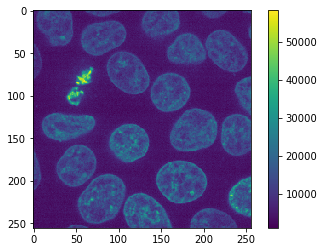

In [2]:
original_image = cells3d()[30, 1]
cle.imshow(original_image, colorbar=True)

## Warum JPEG vermieden werden sollte
Das JPEG-Dateiformat ist, zumindest standardmäßig in vielen Programmen, ein verlustbehaftetes Dateiformat. Das bedeutet, dass beim Speichern des Bildes Informationen verloren gehen.

In [3]:
imsave("temp.jpg", original_image)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


Die obige Warnung bestätigt dies. Wenn wir das Bild neu laden, können wir außerdem in der Farbskala sehen, dass der Intensitätsbereich jetzt anders ist.

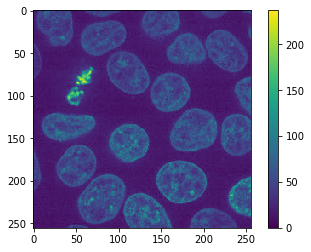

In [4]:
jpg_image = imread("temp.jpg")

cle.imshow(jpg_image, colorbar=True)

Wenn wir weiter hineinzoomen, können wir zwei Arten von typischen JPEG-Artefakten sehen.
* Das Bild ist entrauscht.
* Wir sehen Flecken, z.B. 8x8 Pixel groß, und Streifen, die in verschiedene Richtungen verlaufen.

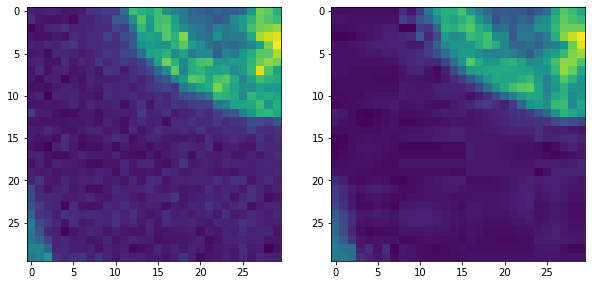

In [5]:
fix, axs = plt.subplots(1,2,figsize=(10,10))

cle.imshow(original_image[140:170, 0:30], plot=axs[0])
cle.imshow(jpg_image[140:170, 0:30], plot=axs[1])

Um diese Fehler quantitativ zu untersuchen und auch mehrere Dateiformate zu testen, schreiben wir eine kurze Funktion, die das Bild speichert und neu lädt und eine Tabelle mit einigen Messungen ausgibt.

In [6]:
def resave_image_statistics(original_image):
    """Speichert und lädt ein Bild in mehreren Formaten und gibt eine Tabelle mit Bildstatistiken zurück."""

    # Tabelle vorbereiten
    stats = {
        "ending":[],
        "data_type":[],
        "shape":[],
        "size":[],
        "min":[],
        "max":[],
        "mean":[],
        "standard_deviation":[],
        "mean_squared_error":[],
    }
    
    # verschiedene Dateiendungen durchgehen
    endings = [None, "tif","png","mhd","mha","jpg","gif","bmp"]
    for ending in endings:
        try:
            if ending is None:
                # Originalbild als ersten Test verwenden
                reloaded_image = original_image
                size = np.NaN
            else:
                # Bild speichern und neu laden
                filename = "temp." + ending
                imsave(filename, original_image)

                reloaded_image = imread(filename)
                size = os.path.getsize(filename)
            
            # Statistiken ermitteln
            stats["ending"].append(ending)
            stats["data_type"].append(reloaded_image.dtype)
            stats["shape"].append(reloaded_image.shape)
            stats["size"].append(size)
            stats["min"].append(np.min(reloaded_image))
            stats["max"].append(np.max(reloaded_image.astype(float)))
            stats["mean"].append(np.mean(reloaded_image))
            stats["standard_deviation"].append(np.std(reloaded_image))

            stats["mean_squared_error"].append(np.mean((original_image - reloaded_image)**2))

        except ValueError:
            # einige Formate werden nicht unterstützt
            warnings.warn("Dateiformat nicht unterstützt: " + ending)
            pass

    return pd.DataFrame(stats)

Als nächstes wenden wir diese Funktion auf einen 2D-Bildschnitt an.

In [7]:
resave_image_statistics(cells3d()[30, 1])

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


ending data_type       shape      size   min      max         mean  \
0   None    uint16  (256, 256)       NaN  1091  58327.0  9346.115417   
1    tif    uint16  (256, 256)  131328.0  1091  58327.0  9346.115417   
2    png    uint16  (256, 256)  107470.0  1091  58327.0  9346.115417   
3    mhd    uint16  (256, 256)     281.0  1091  58327.0  9346.115417   
4    mha    uint16  (256, 256)  131350.0  1091  58327.0  9346.115417   
5    jpg     uint8  (256, 256)    9271.0     0    237.0    36.005875   
6    gif     uint8  (256, 256)   58225.0     4    227.0    36.014725   
7    bmp     uint8  (256, 256)   66614.0     4    227.0    36.014725   

   standard_deviation  mean_squared_error  
0         6139.322637            0.000000  
1         6139.322637            0.000000  
2         6139.322637            0.000000  
3         6139.322637            0.000000  
4         6139.322637            0.000000  
5           23.824527        32596.059555  
6           23.978329        32236.271164  
7           23.978329        32236.271164

## Speichern von 3D-Bildern
Wir können die gleiche Funktion verwenden, um zu testen, welche Dateiformate 3D-Bilder unterstützen.

In [8]:
resave_image_statistics(cells3d()[30])

File format not supported: png
File format not supported: mhd
File format not supported: mha
File format not supported: jpg
File format not supported: gif
File format not supported: bmp


ending data_type          shape      size  min      max         mean  \
0   None    uint16  (2, 256, 256)       NaN  277  58327.0  5925.968422   
1    tif    uint16  (2, 256, 256)  262566.0  277  58327.0  5925.968422   

   standard_deviation  mean_squared_error  
0         5711.584119                 0.0  
1         5711.584119                 0.0

## Speichern von 4D-Bildern
Der `cells3d`-Datensatz ist eigentlich ein 4D-Datensatz. Er enthält auch Kanäle. Daher können wir ihn auch verwenden, um das Speichern und Neuladen von 4D-Daten zu testen.

In [9]:
resave_image_statistics(cells3d())

File format not supported: png
File format not supported: mhd
File format not supported: mha
File format not supported: jpg
File format not supported: gif
File format not supported: bmp


ending data_type              shape        size  min      max        mean  \
0   None    uint16  (60, 2, 256, 256)         NaN    0  65535.0  4837.14054   
1    tif    uint16  (60, 2, 256, 256)  15748650.0    0  65535.0  4837.14054   

   standard_deviation  mean_squared_error  
0         3985.348828                 0.0  
1         3985.348828                 0.0

Daher kann das TIF-Dateiformat empfohlen werden. Es ist auch mit einer Vielzahl anderer Software wie [ImageJ](https://imagej.net) und [Fiji](https://fiji.sc) kompatibel.

## Übung
Ermitteln Sie, ob die Dateiformate 'ico' und 'raw' unterstützt werden.